# 1. Mounting drive on Google Colab

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# 2. Importing libraries

In [0]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pprint
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report, roc_curve
from sklearn.model_selection import GridSearchCV

# 3. Loading datasets

In [163]:
df_users = pd.read_csv('/content/drive/My Drive/takehome_users.csv',encoding = "ISO-8859-1")
df_users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [156]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [6]:
df_engagement = pd.read_csv('/content/drive/My Drive/takehome_user_engagement.csv')
df_engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


# 4. Data wrangling

**Question**: Defining an "adopted user" as a user who has logged into the product on three separate
days in at least one sevenday
period , identify which factors predict future user
adoption .

In [7]:
df_engagement['user_id'].unique()

array([    1,     2,     3, ..., 11998, 11999, 12000])

In [106]:
user_logins = df_engagement[['user_id','time_stamp']].sort_values('user_id')
user_logins.index = df_engagement['time_stamp'].apply(pd.to_datetime)
user_logins.head()

,user_id,time_stamp
time_stamp,,
2014-04-22 03:53:30,1,2014-04-22 03:53:30
2013-11-15 03:45:04,2,2014-03-31 03:45:04
2013-11-29 03:45:04,2,2014-03-13 03:45:04
2013-12-09 03:45:04,2,2014-03-09 03:45:04
2013-12-25 03:45:04,2,2014-02-16 03:45:04


In [110]:
df_seven_days = user_logins.groupby('user_id')['time_stamp'].resample('7D').count()
df_seven_days.head(50)

user_id  time_stamp
1        2014-04-22    1
2        2013-11-15    1
         2013-11-22    0
         2013-11-29    1
         2013-12-06    1
         2013-12-13    0
         2013-12-20    1
         2013-12-27    1
         2014-01-03    1
         2014-01-10    0
         2014-01-17    0
         2014-01-24    0
         2014-01-31    1
         2014-02-07    3
         2014-02-14    1
         2014-02-21    0
         2014-02-28    0
         2014-03-07    2
         2014-03-14    0
         2014-03-21    0
         2014-03-28    1
3        2013-03-19    1
4        2013-05-22    1
5        2013-01-22    1
6        2013-12-19    1
7        2012-12-20    1
10       2013-01-16    2
         2013-01-23    0
         2013-01-30    2
         2013-02-06    1
         2013-02-13    3
         2013-02-20    1
         2013-02-27    3
         2013-03-06    1
         2013-03-13    2
         2013-03-20    3
         2013-03-27    0
         2013-04-03    1
         2013-04-10    3
     

In [130]:
df_three_in_seven = pd.DataFrame(df_seven_days)
df_three_in_seven.columns = ['count']
df_three_in_seven = df_three_in_seven[df_three_in_seven>=3].dropna()
df_three_in_seven

count
user_id time_stamp       
2       2014-02-07    3.0
10      2013-02-13    3.0
        2013-02-27    3.0
        2013-03-20    3.0
        2013-04-10    3.0
...                   ...
11988   2014-03-31    3.0
        2014-04-28    4.0
        2014-05-12    3.0
        2014-05-19    5.0
        2014-05-26    3.0

[33897 rows x 1 columns]

### Identifying unique adopted users

In [148]:
adopted_users = pd.Series(list(zip(*df_three_in_seven.index))[0]).unique()
print (adopted_users)
print (len(adopted_users))

[    2    10    20 ... 11969 11975 11988]
1472


There are a total of 1472 adopted users. Now we need to apply this to our main dataset. 

In [164]:
df_users['adopted_user'] = df_users['object_id'].apply(lambda x: x in adopted_users).map(int)
df_users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0


We now have a variable which determines whether a user is an adopted user or not. 

# 5. Exploratory data analysis

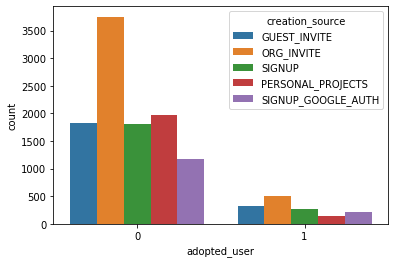

In [166]:
sns.countplot(x='adopted_user',hue='creation_source',data=df_users)

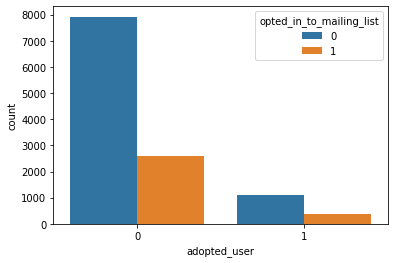

In [167]:
sns.countplot(x='adopted_user',hue='opted_in_to_mailing_list',data=df_users)

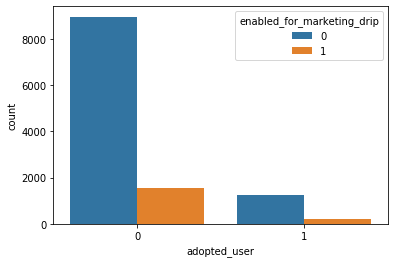

In [168]:
sns.countplot(x='adopted_user',hue='enabled_for_marketing_drip',data=df_users)

In [170]:
df_users['creation_time'] = df_users['creation_time'].apply(pd.to_datetime)
df_users['month_of_creation'] = df_users['creation_time'].apply(lambda x: x.month)
df_users['month_of_creation'].head()

0     4
1    11
2     3
3     5
4     1
Name: month_of_creation, dtype: int64

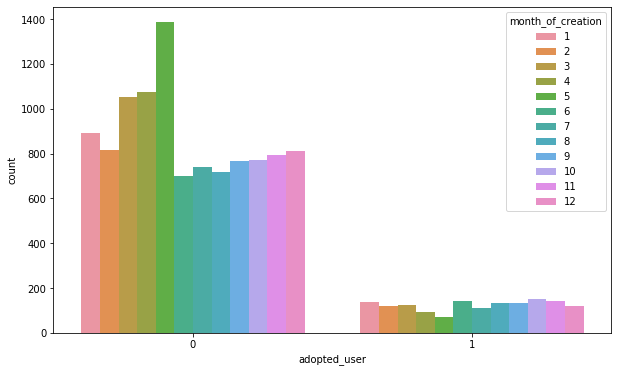

In [173]:
plt.figure(figsize=(10,6))
sns.countplot(x='adopted_user',hue='month_of_creation',data=df_users)

At least from the month of creation data, it appears that people who tend to signup during May (5) don't tend to be adopted users. In fact, May has the lowest frequency for adopted users. Also, there is a steady decline in signups for adopted users from Jan to May whereas for other users, there is an increase. 